In [132]:
# Data
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import impl.layer as l

# Dataset preparation and pre-processing
mnist = input_data.read_data_sets('data/MNIST_data/', one_hot=False)

X_train, y_train = mnist.train.images, mnist.train.labels
X_val, y_val = mnist.validation.images, mnist.validation.labels
X_test, y_test = mnist.test.images, mnist.test.labels
# y_test.shape, y_val.shape, y_train.shape
# X_train.shape, X_train.dtype, X_val.shape, X_val.dtype, X_test.shape, X_test.dtype

Extracting data/MNIST_data/train-images-idx3-ubyte.gz
Extracting data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting data/MNIST_data/t10k-labels-idx1-ubyte.gz


In [133]:
# Pre-processing: normalizing
def normalize(X):
    # max scale for images 255= 2**8= 8 bit grayscale for each channel
    return (X - X.mean(axis=0)) #/ X.std(axis=0)

X_train, X_val, X_test = normalize(X=X_train), normalize(X=X_val), normalize(X=X_test)

In [134]:
# sample = np.random.uniform(high=10, low=0, size=(1,10))
# sample.shape, sample.dtype, sample

In [135]:
# # np.exp(sample)/np.exp(sample).sum(axis=1)
# # # sample.shape, sample.dtype
# np.exp(sample)/ np.exp(sample).sum(axis=1).reshape(-1, 1)

In [136]:
# def softmax(X):
# #     eX = np.exp((X.T - np.max(X, axis=1)).T)
#     eX = np.exp(X.T)
#     return (eX.T / eX.sum(axis=1)).T

In [137]:
# softmax(X=sample), np.exp(sample.T)

In [138]:
# Model
import impl.layer as l # or from impl.layer import *
from impl.loss import * # import all functions from impl.loss file # import impl.loss as loss_func
from sklearn.utils import shuffle as skshuffle

class FFNN:

    def __init__(self, D, C, H, L):
        self.L = L # number of layers or depth
        self.losses = {'train':[], 'valid':[], 'valid_acc':[]}
        
        # The adaptive/learnable/updatable random feedforward
        self.model = []
        self.W_fixed = []
        self.grads = []
        low, high = -1, 1
        
        # Input layer: weights/ biases
        m = dict(W=np.random.uniform(size=(D, H), low=low, high=high) / np.sqrt(D / 2.), b=np.zeros((1, H)))
        self.model.append(m)
        # Fixed feedback weight
        m = np.random.uniform(size=(D, H), low=low, high=high) / np.sqrt(D / 2.)
        self.W_fixed.append(m)
        # Input layer: gradients
        self.grads.append({key: np.zeros_like(val) for key, val in self.model[0].items()})

        # Hidden layers: weights/ biases
        m_L = []
        for _ in range(L):
            m = dict(W=np.random.uniform(size=(H, H), low=low, high=high) / np.sqrt(H / 2.), b=np.zeros((1, H)))
            m_L.append(m)
        self.model.append(m_L)
        # Fixed feedback weight
        m_L = []
        for _ in range(L):
            m = np.random.uniform(size=(H, H), low=low, high=high) / np.sqrt(H / 2.)
            m_L.append(m)
        self.W_fixed.append(m_L)
        # Hidden layer: gradients
        grad = []
        for layer in range(L):
            grad.append({key: np.zeros_like(val) for key, val in self.model[1][layer].items()})
        self.grads.append(grad)
        
        # Output layer: weights/ biases
        m = dict(W=np.random.uniform(size=(H, C), low=low, high=high) / np.sqrt(H / 2.), b=np.zeros((1, C)))
        self.model.append(m)
        # Fixed feedback weight
        m = np.random.uniform(size=(H, C), low=low, high=high) / np.sqrt(H / 2.)
        self.W_fixed.append(m)
        # Outout layer: gradients
        self.grads.append({key: np.zeros_like(val) for key, val in self.model[2].items()})
        
    def fc_forward(self, X, W, b):
        out = (X @ W) + b
        cache = (W, X)
        return out, cache

    def fc_backward(self, dout, cache, W_fixed):
        W, X = cache

        dW = X.T @ dout
        db = np.sum(dout, axis=0).reshape(1, -1) # db_1xn
        
        # dX = dout @ W.T # Backprop
        dX = dout @ W_fixed.T # fb alignment

        return dX, dW, db

    def train_forward(self, X):
        caches = []
        
        # Input layer
        y, fc_cache = self.fc_forward(X=X, W=self.model[0]['W'], b=self.model[0]['b']) # X_1xD, y_1xc
        y, nl_cache = l.selu_forward(X=y)
#         y = np.exp(y) #/ np.exp(y).sum(axis=1).reshape(-1, 1) # txn
        X = y.copy() # pass to the next layer
        caches.append((fc_cache, nl_cache)) # caches[0]
        
        # Hidden layers
        fc_caches, nl_caches = [], []
        for layer in range(self.L):
            y, fc_cache = self.fc_forward(X=X, W=self.model[1][layer]['W'], b=self.model[1][layer]['b'])
            y, nl_cache = l.selu_forward(X=y)
#             y = np.exp(y) #/ np.exp(y).sum(axis=1).reshape(-1, 1) # txn
            X = y.copy() # pass to next layer
            fc_caches.append(fc_cache)
            nl_caches.append(nl_cache)
        caches.append((fc_caches, nl_caches)) # caches[1]
        
        # Output layer
        y, fc_cache = self.fc_forward(X=X, W=self.model[2]['W'], b=self.model[2]['b'])
        caches.append(fc_cache) # caches[2]

        return y, caches

    def loss_function(self, y, y_train):
        
        loss = cross_entropy(y, y_train) # softmax is included
        dy = dcross_entropy(y, y_train) # dsoftmax is included
        
        return loss, dy
        
    def train_backward(self, dy, caches):
        grads = self.grads # initialized by Zero in every iteration/epoch
        
        # Output layer
        fc_cache = caches[2]
        dX, dW, db = self.fc_backward(dout=dy, cache=fc_cache, W_fixed=self.W_fixed[2])
        dy = dX.copy()
        grads[2]['W'] = dW
        grads[2]['b'] = db

        # Hidden layer
        fc_caches, nl_caches = caches[1]
        for layer in reversed(range(self.L)):
            dy = l.selu_backward(cache=nl_caches[layer], dout=dy)
#             dy = np.exp(dy) #/ np.exp(dy).sum(axis=1).reshape(-1, 1) # txn
            dX, dW, db = self.fc_backward(dout=dy, cache=fc_caches[layer], W_fixed=self.W_fixed[1][layer])
            dy = dX.copy()
            grads[1][layer]['W'] = dW
            grads[1][layer]['b'] = db
        
        # Input layer
        fc_cache, nl_cache = caches[0]
        dy = l.selu_backward(cache=nl_cache, dout=dy)
#         dy = np.exp(dy) #/ np.exp(dy).sum(axis=1).reshape(-1, 1) # txn
        dX, dW, db = self.fc_backward(dout=dy, cache=fc_cache, W_fixed=self.W_fixed[0])
        # dy = dX.copy()
        grads[0]['W'] = dW
        grads[0]['b'] = db

        return dX, grads
    
    def test(self, X):
        y_logit, _ = self.train_forward(X)
        
        # if self.mode == 'classification':
        y_prob = l.softmax(y_logit) # for accuracy == acc
        y_pred = np.argmax(y_prob, axis=1) # for loss ==err
        
        return y_pred, y_logit
        
    def get_minibatch(self, X, y, minibatch_size, shuffle):
        minibatches = []

        if shuffle:
            X, y = skshuffle(X, y)

        for i in range(0, X.shape[0], minibatch_size):
            X_mini = X[i:i + minibatch_size]
            y_mini = y[i:i + minibatch_size]
            minibatches.append((X_mini, y_mini))

        return minibatches

    def sgd(self, train_set, val_set, alpha, mb_size, n_iter, print_after):
        X_train, y_train = train_set
        X_val, y_val = val_set

        # Epochs
        for iter in range(1, n_iter + 1):

            # Minibatches
            minibatches = self.get_minibatch(X_train, y_train, mb_size, shuffle=True)
            idx = np.random.randint(0, len(minibatches))
            X_mini, y_mini = minibatches[idx]
            
            # Train the model
            y, caches = self.train_forward(X_mini)
            loss, dy = self.loss_function(y, y_mini)
            _, grads = self.train_backward(dy, caches)
            self.losses['train'].append(loss)
            
            # Update the model for input layer
            for key in grads[0].keys():
                self.model[0][key] -= alpha * grads[0][key]

            # Update the model for the hidden layers
            for layer in range(self.L):
                for key in grads[1][layer].keys():
                    self.model[1][layer][key] -= alpha * grads[1][layer][key]

            # Update the model for output layer
            for key in grads[2].keys():
                self.model[2][key] -= alpha * grads[2][key]
                
            # Validate the updated model
            y_pred, y_logit = self.test(X_val)
            valid_loss, _ = self.loss_function(y_logit, y_val) # softmax is included in entropy loss function
            self.losses['valid'].append(valid_loss)
            valid_acc = np.mean(y_pred == y_val) # confusion matrix
            self.losses['valid_acc'].append(valid_acc)
            
            # Print the model info: loss & accuracy or err & acc
            if iter % print_after == 0:
                print('Iter-{} train loss: {:.4f} valid loss: {:.4f}, valid accuracy: {:.4f}'.format(
                    iter, loss, valid_loss, valid_acc))

        # Test the final model
        y_pred, y_logit = nn.test(X_test)
        loss, _ = self.loss_function(y_logit, y_test) # softmax is included in entropy loss function
        acc = np.mean(y_pred == y_test)
        print('Last iteration - Test accuracy mean: {:.4f}, std: {:.4f}, loss: {:.4f}'.format(
            acc.mean(), acc.std(), loss))

In [139]:
# Hyper-parameters
n_iter = 10000 # number of epochs
alpha = 1e-3 # learning_rate
mb_size = 64 # 2**10==1024 # width, timestep for sequential data or minibatch size
print_after = 10 # n_iter//10 # print loss for train, valid, and test
num_hidden_units = 32 # number of kernels/ filters in each layer
num_input_units = X_train.shape[1] # noise added at the input lavel as input noise we can use dX or for more improvement
num_output_units = y_train.max() + 1 # number of classes in this classification problem
num_layers = 1 # depth 

# Build the model/NN and learn it: running session.
nn = FFNN(C=num_output_units, D=num_input_units, H=num_hidden_units, L=num_layers)

nn.sgd(train_set=(X_train, y_train), val_set=(X_val, y_val), mb_size=mb_size, alpha=alpha, 
           n_iter=n_iter, print_after=print_after)

Iter-10 train loss: 2.3812 valid loss: 2.3893, valid accuracy: 0.0776
Iter-20 train loss: 2.3830 valid loss: 2.3878, valid accuracy: 0.0790
Iter-30 train loss: 2.3711 valid loss: 2.3864, valid accuracy: 0.0786
Iter-40 train loss: 2.3961 valid loss: 2.3846, valid accuracy: 0.0792
Iter-50 train loss: 2.3360 valid loss: 2.3829, valid accuracy: 0.0792
Iter-60 train loss: 2.3935 valid loss: 2.3815, valid accuracy: 0.0794
Iter-70 train loss: 2.3013 valid loss: 2.3798, valid accuracy: 0.0796
Iter-80 train loss: 2.3988 valid loss: 2.3783, valid accuracy: 0.0802
Iter-90 train loss: 2.3118 valid loss: 2.3766, valid accuracy: 0.0812
Iter-100 train loss: 2.3635 valid loss: 2.3749, valid accuracy: 0.0814
Iter-110 train loss: 2.3998 valid loss: 2.3733, valid accuracy: 0.0822
Iter-120 train loss: 2.3535 valid loss: 2.3715, valid accuracy: 0.0836
Iter-130 train loss: 2.3291 valid loss: 2.3697, valid accuracy: 0.0836
Iter-140 train loss: 2.3366 valid loss: 2.3682, valid accuracy: 0.0844
Iter-150 train 

Iter-1170 train loss: 2.0453 valid loss: 2.0572, valid accuracy: 0.2640
Iter-1180 train loss: 2.1497 valid loss: 2.0529, valid accuracy: 0.2680
Iter-1190 train loss: 2.0813 valid loss: 2.0486, valid accuracy: 0.2740
Iter-1200 train loss: 2.0972 valid loss: 2.0443, valid accuracy: 0.2800
Iter-1210 train loss: 1.9570 valid loss: 2.0400, valid accuracy: 0.2858
Iter-1220 train loss: 2.0348 valid loss: 2.0358, valid accuracy: 0.2914
Iter-1230 train loss: 2.0167 valid loss: 2.0313, valid accuracy: 0.2960
Iter-1240 train loss: 1.9763 valid loss: 2.0273, valid accuracy: 0.3002
Iter-1250 train loss: 2.0703 valid loss: 2.0231, valid accuracy: 0.3034
Iter-1260 train loss: 1.9835 valid loss: 2.0186, valid accuracy: 0.3076
Iter-1270 train loss: 2.0061 valid loss: 2.0143, valid accuracy: 0.3104
Iter-1280 train loss: 2.0538 valid loss: 2.0099, valid accuracy: 0.3160
Iter-1290 train loss: 2.0621 valid loss: 2.0056, valid accuracy: 0.3184
Iter-1300 train loss: 2.0793 valid loss: 2.0012, valid accuracy:

Iter-2310 train loss: 1.4578 valid loss: 1.5996, valid accuracy: 0.5048
Iter-2320 train loss: 1.7523 valid loss: 1.5962, valid accuracy: 0.5056
Iter-2330 train loss: 1.6443 valid loss: 1.5929, valid accuracy: 0.5068
Iter-2340 train loss: 1.6515 valid loss: 1.5895, valid accuracy: 0.5082
Iter-2350 train loss: 1.5935 valid loss: 1.5862, valid accuracy: 0.5096
Iter-2360 train loss: 1.6877 valid loss: 1.5829, valid accuracy: 0.5120
Iter-2370 train loss: 1.5240 valid loss: 1.5794, valid accuracy: 0.5144
Iter-2380 train loss: 1.5491 valid loss: 1.5761, valid accuracy: 0.5158
Iter-2390 train loss: 1.6150 valid loss: 1.5728, valid accuracy: 0.5174
Iter-2400 train loss: 1.6468 valid loss: 1.5695, valid accuracy: 0.5190
Iter-2410 train loss: 1.5510 valid loss: 1.5661, valid accuracy: 0.5230
Iter-2420 train loss: 1.6942 valid loss: 1.5628, valid accuracy: 0.5242
Iter-2430 train loss: 1.7203 valid loss: 1.5595, valid accuracy: 0.5258
Iter-2440 train loss: 1.6890 valid loss: 1.5562, valid accuracy:

Iter-3450 train loss: 1.1492 valid loss: 1.2724, valid accuracy: 0.6280
Iter-3460 train loss: 1.2521 valid loss: 1.2699, valid accuracy: 0.6286
Iter-3470 train loss: 1.1968 valid loss: 1.2677, valid accuracy: 0.6292
Iter-3480 train loss: 1.3446 valid loss: 1.2653, valid accuracy: 0.6302
Iter-3490 train loss: 1.1629 valid loss: 1.2630, valid accuracy: 0.6310
Iter-3500 train loss: 1.2744 valid loss: 1.2606, valid accuracy: 0.6316
Iter-3510 train loss: 1.2444 valid loss: 1.2581, valid accuracy: 0.6324
Iter-3520 train loss: 1.2237 valid loss: 1.2559, valid accuracy: 0.6326
Iter-3530 train loss: 1.3421 valid loss: 1.2536, valid accuracy: 0.6336
Iter-3540 train loss: 1.2574 valid loss: 1.2513, valid accuracy: 0.6340
Iter-3550 train loss: 1.1390 valid loss: 1.2490, valid accuracy: 0.6344
Iter-3560 train loss: 1.1556 valid loss: 1.2467, valid accuracy: 0.6356
Iter-3570 train loss: 1.2349 valid loss: 1.2444, valid accuracy: 0.6364
Iter-3580 train loss: 1.2515 valid loss: 1.2422, valid accuracy:

Iter-4590 train loss: 1.0516 valid loss: 1.0499, valid accuracy: 0.6956
Iter-4600 train loss: 1.0400 valid loss: 1.0484, valid accuracy: 0.6960
Iter-4610 train loss: 0.9795 valid loss: 1.0469, valid accuracy: 0.6964
Iter-4620 train loss: 1.0389 valid loss: 1.0453, valid accuracy: 0.6962
Iter-4630 train loss: 1.0772 valid loss: 1.0437, valid accuracy: 0.6968
Iter-4640 train loss: 1.1042 valid loss: 1.0421, valid accuracy: 0.6972
Iter-4650 train loss: 1.2031 valid loss: 1.0406, valid accuracy: 0.6982
Iter-4660 train loss: 0.9503 valid loss: 1.0390, valid accuracy: 0.6986
Iter-4670 train loss: 1.0057 valid loss: 1.0374, valid accuracy: 0.6998
Iter-4680 train loss: 1.0404 valid loss: 1.0359, valid accuracy: 0.6998
Iter-4690 train loss: 1.0975 valid loss: 1.0344, valid accuracy: 0.7004
Iter-4700 train loss: 0.9923 valid loss: 1.0329, valid accuracy: 0.7010
Iter-4710 train loss: 1.2054 valid loss: 1.0315, valid accuracy: 0.7016
Iter-4720 train loss: 1.2837 valid loss: 1.0300, valid accuracy:

Iter-5730 train loss: 0.8255 valid loss: 0.8980, valid accuracy: 0.7530
Iter-5740 train loss: 0.8866 valid loss: 0.8968, valid accuracy: 0.7536
Iter-5750 train loss: 0.8419 valid loss: 0.8958, valid accuracy: 0.7542
Iter-5760 train loss: 0.8467 valid loss: 0.8946, valid accuracy: 0.7542
Iter-5770 train loss: 1.0066 valid loss: 0.8935, valid accuracy: 0.7544
Iter-5780 train loss: 0.9241 valid loss: 0.8925, valid accuracy: 0.7548
Iter-5790 train loss: 1.0234 valid loss: 0.8914, valid accuracy: 0.7546
Iter-5800 train loss: 0.8632 valid loss: 0.8903, valid accuracy: 0.7562
Iter-5810 train loss: 0.8253 valid loss: 0.8892, valid accuracy: 0.7560
Iter-5820 train loss: 0.9944 valid loss: 0.8881, valid accuracy: 0.7570
Iter-5830 train loss: 1.0219 valid loss: 0.8871, valid accuracy: 0.7570
Iter-5840 train loss: 0.9421 valid loss: 0.8860, valid accuracy: 0.7576
Iter-5850 train loss: 1.1752 valid loss: 0.8849, valid accuracy: 0.7578
Iter-5860 train loss: 1.0283 valid loss: 0.8839, valid accuracy:

Iter-6870 train loss: 0.8189 valid loss: 0.7881, valid accuracy: 0.7892
Iter-6880 train loss: 0.8745 valid loss: 0.7873, valid accuracy: 0.7896
Iter-6890 train loss: 0.9308 valid loss: 0.7865, valid accuracy: 0.7900
Iter-6900 train loss: 0.7469 valid loss: 0.7856, valid accuracy: 0.7900
Iter-6910 train loss: 0.7531 valid loss: 0.7848, valid accuracy: 0.7910
Iter-6920 train loss: 0.6530 valid loss: 0.7840, valid accuracy: 0.7916
Iter-6930 train loss: 0.7159 valid loss: 0.7831, valid accuracy: 0.7920
Iter-6940 train loss: 0.7393 valid loss: 0.7824, valid accuracy: 0.7918
Iter-6950 train loss: 0.8705 valid loss: 0.7815, valid accuracy: 0.7918
Iter-6960 train loss: 0.7897 valid loss: 0.7807, valid accuracy: 0.7920
Iter-6970 train loss: 0.8125 valid loss: 0.7799, valid accuracy: 0.7930
Iter-6980 train loss: 0.8035 valid loss: 0.7791, valid accuracy: 0.7922
Iter-6990 train loss: 0.8507 valid loss: 0.7783, valid accuracy: 0.7928
Iter-7000 train loss: 1.0587 valid loss: 0.7776, valid accuracy:

Iter-8010 train loss: 0.5993 valid loss: 0.7064, valid accuracy: 0.8144
Iter-8020 train loss: 0.8032 valid loss: 0.7057, valid accuracy: 0.8146
Iter-8030 train loss: 0.5193 valid loss: 0.7051, valid accuracy: 0.8148
Iter-8040 train loss: 0.6670 valid loss: 0.7045, valid accuracy: 0.8158
Iter-8050 train loss: 0.6666 valid loss: 0.7038, valid accuracy: 0.8154
Iter-8060 train loss: 0.6524 valid loss: 0.7032, valid accuracy: 0.8160
Iter-8070 train loss: 0.6769 valid loss: 0.7026, valid accuracy: 0.8156
Iter-8080 train loss: 0.7221 valid loss: 0.7020, valid accuracy: 0.8158
Iter-8090 train loss: 0.7239 valid loss: 0.7014, valid accuracy: 0.8156
Iter-8100 train loss: 0.7172 valid loss: 0.7008, valid accuracy: 0.8158
Iter-8110 train loss: 0.8008 valid loss: 0.7002, valid accuracy: 0.8160
Iter-8120 train loss: 0.7570 valid loss: 0.6996, valid accuracy: 0.8166
Iter-8130 train loss: 0.6627 valid loss: 0.6990, valid accuracy: 0.8168
Iter-8140 train loss: 0.7389 valid loss: 0.6984, valid accuracy:

Iter-9150 train loss: 0.7116 valid loss: 0.6450, valid accuracy: 0.8274
Iter-9160 train loss: 0.6105 valid loss: 0.6446, valid accuracy: 0.8274
Iter-9170 train loss: 0.6353 valid loss: 0.6441, valid accuracy: 0.8276
Iter-9180 train loss: 0.5755 valid loss: 0.6436, valid accuracy: 0.8278
Iter-9190 train loss: 0.7739 valid loss: 0.6431, valid accuracy: 0.8282
Iter-9200 train loss: 0.6435 valid loss: 0.6426, valid accuracy: 0.8280
Iter-9210 train loss: 0.6544 valid loss: 0.6421, valid accuracy: 0.8286
Iter-9220 train loss: 0.7121 valid loss: 0.6417, valid accuracy: 0.8286
Iter-9230 train loss: 0.5049 valid loss: 0.6412, valid accuracy: 0.8288
Iter-9240 train loss: 0.8670 valid loss: 0.6408, valid accuracy: 0.8290
Iter-9250 train loss: 0.7369 valid loss: 0.6403, valid accuracy: 0.8294
Iter-9260 train loss: 0.7439 valid loss: 0.6398, valid accuracy: 0.8296
Iter-9270 train loss: 0.6615 valid loss: 0.6394, valid accuracy: 0.8296
Iter-9280 train loss: 0.5520 valid loss: 0.6390, valid accuracy:

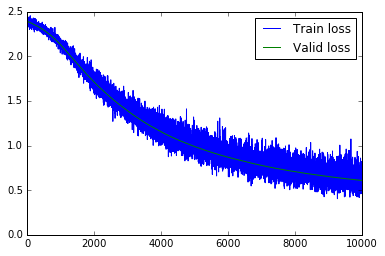

In [140]:
# # Display the learning curve and losses for training, validation, and testing
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.plot(nn.losses['train'], label='Train loss')
plt.plot(nn.losses['valid'], label='Valid loss')
plt.legend()
plt.show()

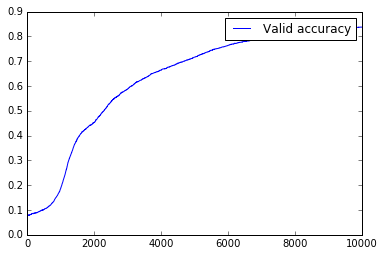

In [141]:
plt.plot(nn.losses['valid_acc'], label='Valid accuracy')
plt.legend()
plt.show()